# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, I will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin (BTC) fear and greed index values to predict the 11th day closing price of BTC. 

Process:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, I will prepare the training and testing data for the model. The model will use a rolling 10 day window of the FNG values to predict the 11th day closing price of BTC.

Data Preparation Process:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [1]:
import numpy as np
import pandas as pd
#import hvplot.pandas

In [2]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [4]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [5]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [6]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [7]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [38]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [39]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [40]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)


In [41]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.33333333]
  [0.10606061]
  [0.48484848]]

 [[0.10606061]
  [0.48484848]
  [0.24242424]]

 [[0.48484848]
  [0.24242424]
  [0.04545455]]

 [[0.24242424]
  [0.04545455]
  [0.        ]]

 [[0.04545455]
  [0.        ]
  [0.42424242]]] 

X_test sample values:
[[[0.34177215]
  [0.3164557 ]
  [0.27848101]]

 [[0.3164557 ]
  [0.27848101]
  [0.59493671]]

 [[0.27848101]
  [0.59493671]
  [0.62025316]]

 [[0.59493671]
  [0.62025316]
  [0.5443038 ]]

 [[0.62025316]
  [0.5443038 ]
  [0.5443038 ]]]


---

## Build and Train the LSTM RNN

In this section, I will design a custom LSTM RNN and train it using the training data set.

Building the LSTM RNN Process:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

*** Note: I will use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model.***

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [43]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model
model = Sequential()

number_units = 3
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output Layer
model.add(Dense(1))


In [44]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [45]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 3, 3)              60        
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 3)              84        
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 3)              0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dropout_8 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [46]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
378/378 [==============================] - 1s 2ms/step - loss: 0.1146
Epoch 2/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0615
Epoch 3/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0572
Epoch 4/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0542
Epoch 5/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0510
Epoch 6/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0516
Epoch 7/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0456
Epoch 8/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0440
Epoch 9/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0477
Epoch 10/10
378/378 [==============================] - 1s 2ms/step - loss: 0.0466


---

## Model Performance

In this section, I will evaluate the model using the test data. 

Model Evaluation Process:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

*** Note: I will apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices. ***

In [47]:
# Evaluate the model
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.0981


0.09806384146213531

In [34]:
# Make some predictions
predicted = model.predict(X_test)

In [35]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [36]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-18,3912.570068,4981.937012
2019-02-19,3924.239990,4936.629395
2019-02-20,3974.050049,5033.025391
2019-02-21,3937.040039,5200.801270
2019-02-22,3983.530029,5474.566895


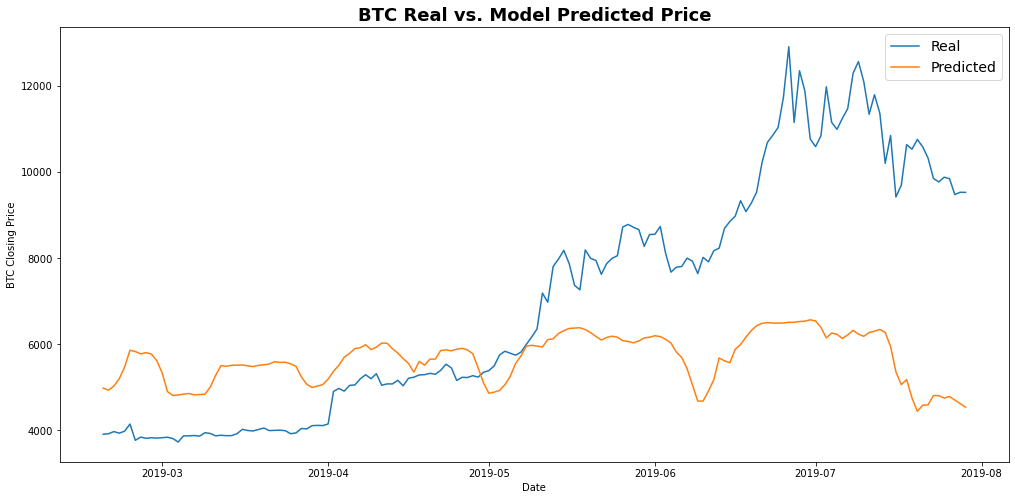

In [37]:
# Plot the real vs predicted values as a line chart
import matplotlib.pyplot as plt
plt.subplots(figsize=(17,8))
plt.plot(stocks)
plt.legend(stocks.columns,prop={'size': 14})
plt.xlabel("Date")
plt.ylabel("BTC Closing Price")
plt.title(f"BTC Real vs. Model Predicted Price", fontdict={'fontweight':'bold', 'fontsize':'18'})
plt.show()